## **Inside Out ML: Emotion Classification from fMRI Using Parcellation and Projection Techniques**

<div style="text-align: center">
    <img src="./cover-img.png" alt="image" width="600" />
</div>

In [20]:
from itertools import product
import joblib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
import nibabel as nib
from nilearn import input_data, plotting
import pandas as pd
from nilearn import datasets as ni_data
from nilearn.image import get_data
import numpy as np
import os
import pandas as pd
from pandas.errors import PerformanceWarning
from pprint import pprint as pp
from scipy import stats
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets as torch_data
import warnings

# **Load Data**

In [31]:
def create_file_list(subs, emotions, primings):
    '''
    purpose: create lists for file names, specified subjects, emotion states and priming conditions
    
    parameters:
        subs: list: subject numbers
        emotions: list: emotion states (anger, fear, disgust)
        priming: list: of priming conditions (congruent,, incongruent, neutral)
    
    output: 
        files (list): list of file names
        subject_no (list): list of subject numbers matching the order of the file names
        emotion_class (list): list of emotion states matching the order of the file names
        priming_class (list): list of priming conditions matching the order of the file names
        
    '''

    # intialize vars
    files = []
    subject_no = []
    emotion_class = []
    priming_class = []

    # iterate over the different classes
    for sub in subs:
        for emo in emotions: 
            for priming in primings:
    
                # get the subject as a string
                if sub // 10 == 0:
                    sub_str = '00' + str(sub)
                else:
                    sub_str = '0' + str(sub)
                
                # create the filename and add to list
                filename = './emotion-fmri-neu/cp' + sub_str + '_beta_' + emo + '_' + priming + '_c0.nii.gz'
                files.append(filename)
                subject_no.append(sub)
                emotion_class.append(emo)
                priming_class.append(priming)

    return files, subject_no, emotion_class, priming_class

In [32]:
def create_dataset(files):
    '''
    purpose: generate dataset of image_da tuple of file names, specified subjects, emotion states and priming conditions
    
    parameters:
        none
    
    output: 
        image_data: np.array: 4D array of voxel brain data for 270 test subjects
    '''

    # convert image data to NumPy array
    image_list = []

    for f in files:
        img = nib.load(f)
        data = img.get_fdata()
        image_list.append(data)

    # stack all into one 4D array: (270, 91, 109, 91)
    image_data = np.stack(image_list)

    return image_data
    


In [40]:
# create lists for classes and filenames
subjects = range(1,4)
emotions = ['anger', 'fear', 'disgust']
primings = ['congruent', 'incongruent', 'neutral']
files, subject_no, emotion_class, priming_class = create_file_list(subjects, emotions, primings)

In [12]:
def parcellation_atlas_dict():
    
    '''
    purpose: create a dictionaries for all parcellation techniques with their respective maps and labels
    parameters: none
    output: 
        tuple: 
            maps: dict: brain parcellation atlas maps in the NiLearn dataset  
            regions: dict: brain regions correlated to each map  
    '''
    
    # Harvard Oxford Atlases
    harvard_oxford_cort_0_1 = ni_data.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm')
    harvard_oxford_cortl_0_1 = ni_data.fetch_atlas_harvard_oxford('cortl-maxprob-thr0-1mm')
    harvard_oxford_sub_0_1 = ni_data.fetch_atlas_harvard_oxford('sub-maxprob-thr0-1mm')

    # Juelich Atlas
    juelich_0_1 = ni_data.fetch_atlas_juelich('maxprob-thr0-1mm')

    # AAL templates
    aal_spm12 = ni_data.fetch_atlas_aal('SPM12')

    # Talairach atlases
    talairach_hemi = ni_data.fetch_atlas_talairach('hemisphere')
    talairach_lobe = ni_data.fetch_atlas_talairach('lobe')
    talairach_gyrus = ni_data.fetch_atlas_talairach('gyrus')
    talairach_tissue = ni_data.fetch_atlas_talairach('tissue')
    talairach_ba = ni_data.fetch_atlas_talairach('ba')

    # Schaefer 2018 atlas
    schaefer_100_7_1 = ni_data.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)

    maps = {
              'Harvard_Oxford cort 0 x 1': harvard_oxford_cort_0_1.maps, 'Harvard_Oxford cortl 0 x 1': harvard_oxford_cortl_0_1.maps,
              'Harvard_Oxford sub 0 x 1': harvard_oxford_sub_0_1.maps, 'Juelich 0 x 1' : juelich_0_1.maps, 'AAL SPM12' : aal_spm12.maps,
               'Talairach Hemi' : talairach_hemi.maps, 'Talairach Lobe' : talairach_lobe.maps, 'Talairach Gyrus' : talairach_gyrus.maps,
               'Talairach Tissue' : talairach_tissue.maps, 'Talairach Ba' : talairach_ba.maps,
              'Schaefer 100 x 7 x 1' : schaefer_100_7_1.maps,
            }


    regions = {
              'Harvard_Oxford cort 0 x 1': harvard_oxford_cort_0_1.labels, 'Harvard_Oxford cortl 0 x 1': harvard_oxford_cortl_0_1.labels,
              'Harvard_Oxford sub 0 x 1': harvard_oxford_sub_0_1.labels, 'Juelich 0 x 1' : juelich_0_1.labels, 'AAL SPM12' : aal_spm12.labels,
               'Talairach Hemi' : talairach_hemi.labels, 'Talairach Lobe' : talairach_lobe.labels, 'Talairach Gyrus' : talairach_gyrus.labels,
               'Talairach Tissue' : talairach_tissue.labels, 'Talairach Ba' : talairach_ba.labels,
              'Schaefer 100 x 7 x 1' : schaefer_100_7_1.labels,
            }

    return maps, regions


In [13]:
maps, regions = parcellation_atlas_dict()

parcellation_methods = ['Harvard_Oxford cort 0 x 1', 'Harvard_Oxford cortl 0 x 1', 'Harvard_Oxford sub 0 x 1', 'Juelich 0 x 1', 
                        'AAL SPM12', 'Talairach Gyrus', 'Talairach Ba', 'Schaefer 100 x 7 x 1', 'Talairach Hemi x Lobe x Tissue']

projection_methods= ['PCA', 'Isomap', 'Hessian', 'MDS', 't-SNE']

In [14]:
parcellations = {key: pd.read_csv(f'./data/parcellations/{key}.csv') for key in parcellation_methods}
projections = {key: pd.read_csv(f'./data/projections/{key}.csv') for key in projection_methods}

# **Exploratory Data Analysis**

## **Brain Parcellation Visuals**

In [18]:
def plot_parcellation_map(atlas, maps, cut_coords = (3,-30,13)):
    '''
    purpose: plot visualization to show the areas of the brain divivded in parcellation atlas
        
    params:
        atlas_name : str: Name of brain parcellation technique  
        atlas_types : dict: Dictionary of parcellation atlases and their maps and labels   
        cut_coords : tuple Coordinates for brain visualization
    
    output: none, displays visualization of brain data
    '''
    
    atlas_map = maps[atlas]
    
    if type(atlas_map) == tuple:
        atlas_map = atlas_map[0]
    
    if type(atlas_map) == str or list:
        dim = get_data(atlas_map).ndim
        
    else:
        dim = atlas_map.ndim
    
    if dim == 4:
        plotting.plot_prob_atlas(atlas_map, cut_coords = cut_coords, title = atlas, black_bg=True)
        plt.show()
        
    else:
        plotting.plot_roi(atlas_map, cut_coords=cut_coords, title = atlas, black_bg = True)
        plt.show()

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


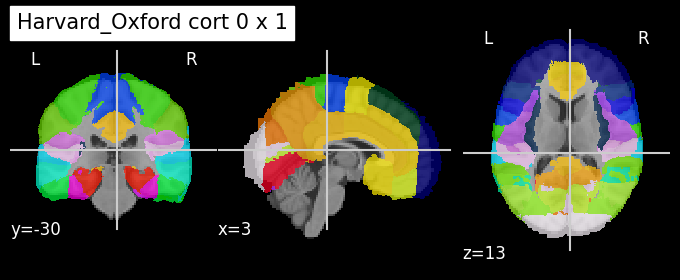

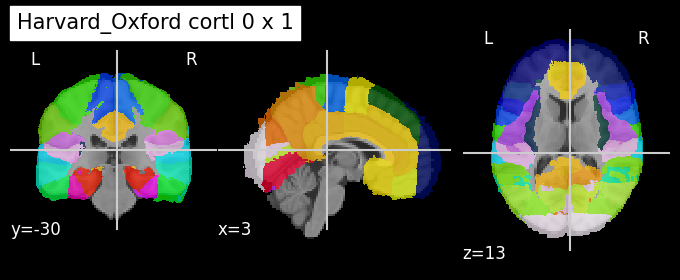

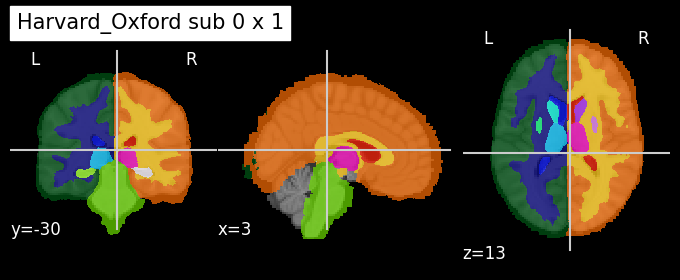

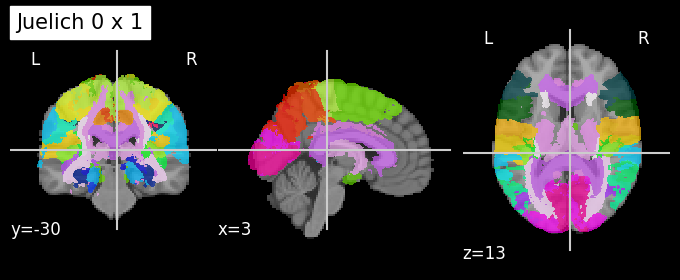

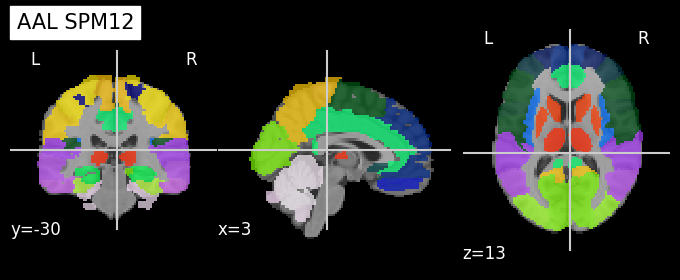

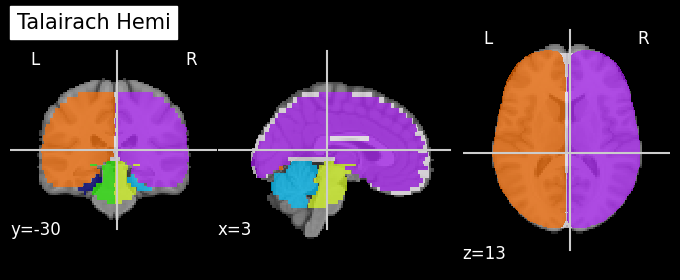

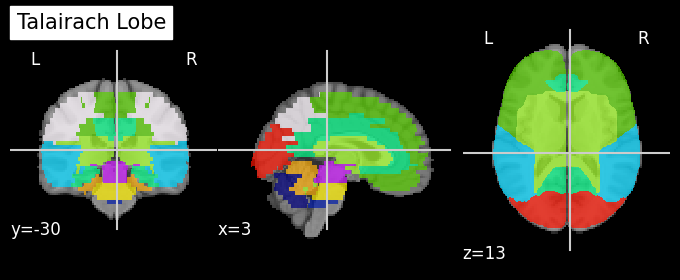

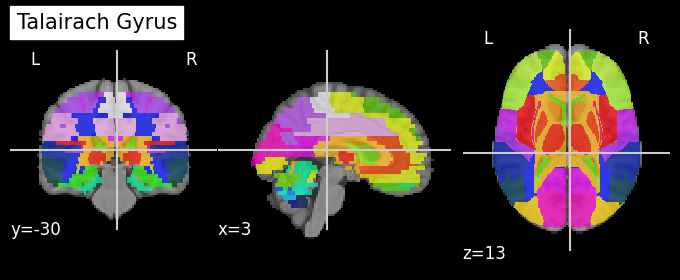

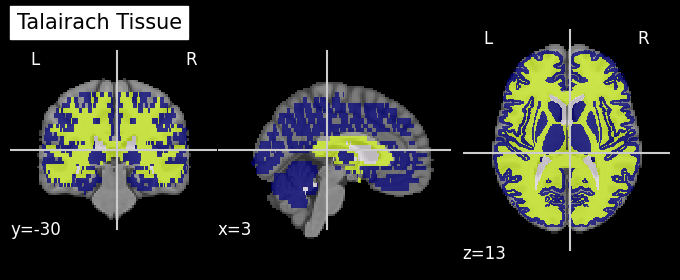

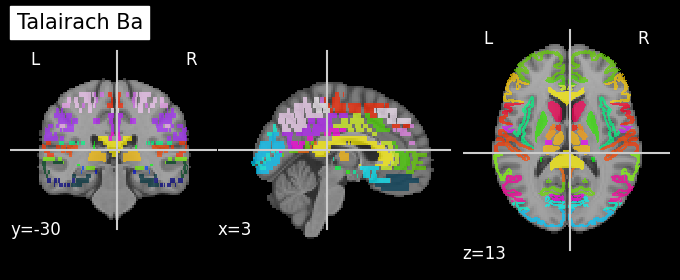

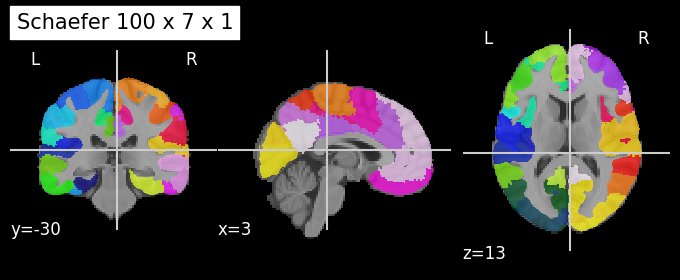

In [21]:
# for each brain parcellation, generate the visual map
for k in maps.keys():
    plot_parcellation_map(k, maps)

## **Geometric Projection Visuals**

Visualize at linearly separability in 2D space

In [42]:
# encode your categorical labels into numerical values
le_emotion = LabelEncoder()
le_subject = LabelEncoder()
le_priming = LabelEncoder()

# Fit and transform the categorical data
emotion_encoded = le_emotion.fit_transform(emotion_class) 
subject_encoded = le_subject.fit_transform(subject_no)
priming_encoded = le_priming.fit_transform(priming_class) 

projection_2D = {key: pd.read_csv(f'./data/bivariate_data/{key}.csv') for key in projection_methods}

In [45]:
def plot_embeddings(X_emb, y_encoded, title, target, filename, label_encoder):
    '''
    purpose: plot 2D embeddings with numerical labels
    params:
        X_emb: 2D array of embeddings
        y_encoded: 1D array of numerical labels (e.g., output of LabelEncoder)
        title: str, plot title
        filename: str, optional, name to save the plot
        label_encoder: sklearn.preprocessing.LabelEncoder, optional, to show original labels in colorbar
    output: none, shows plot and saves to directory
    '''

    plt.figure(figsize=(10, 8))
    num_classes = len(np.unique(y_encoded))

    feat_1 = X_emb.columns[0]
    feat_2 = X_emb.columns[1]
    X_emb = np.array(X_emb[[feat_1, feat_2]])
    
    base_cmap = colormaps.get_cmap('prism').resampled(num_classes)
    custom_cmap = ListedColormap([base_cmap(i) for i in range(num_classes)])

    scatter = plt.scatter(X_emb[:,0], X_emb[:,1], c=y_encoded, cmap=custom_cmap, alpha=0.6)
    
    cbar = plt.colorbar(scatter, ticks=np.unique(y_encoded), label='Class')
    cbar.ax.set_yticklabels(label_encoder.inverse_transform(np.unique(y_encoded)))

    plt.title(title)
    plt.xlabel(feat_1)
    plt.ylabel(feat_2)
    plt.show()

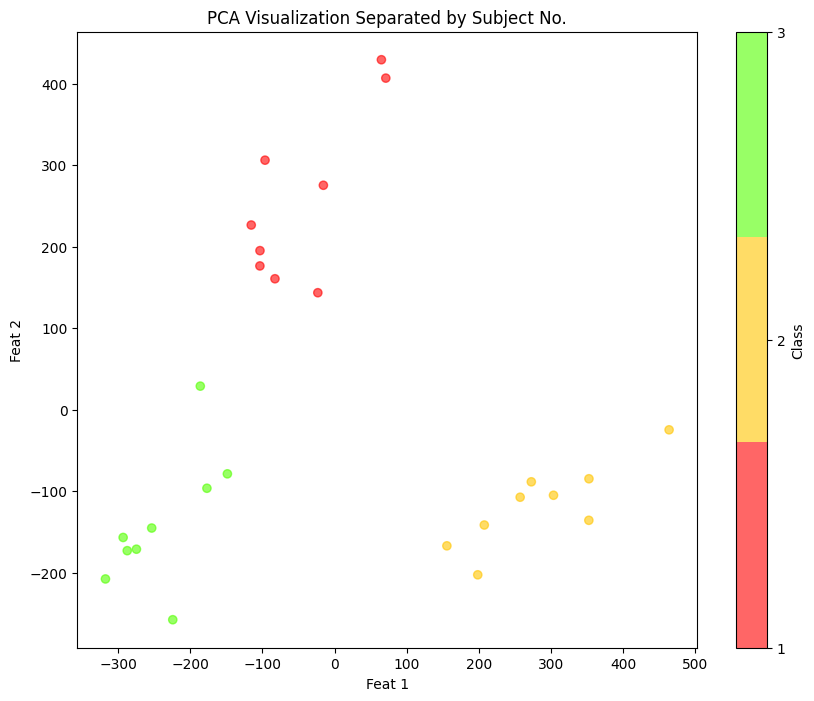

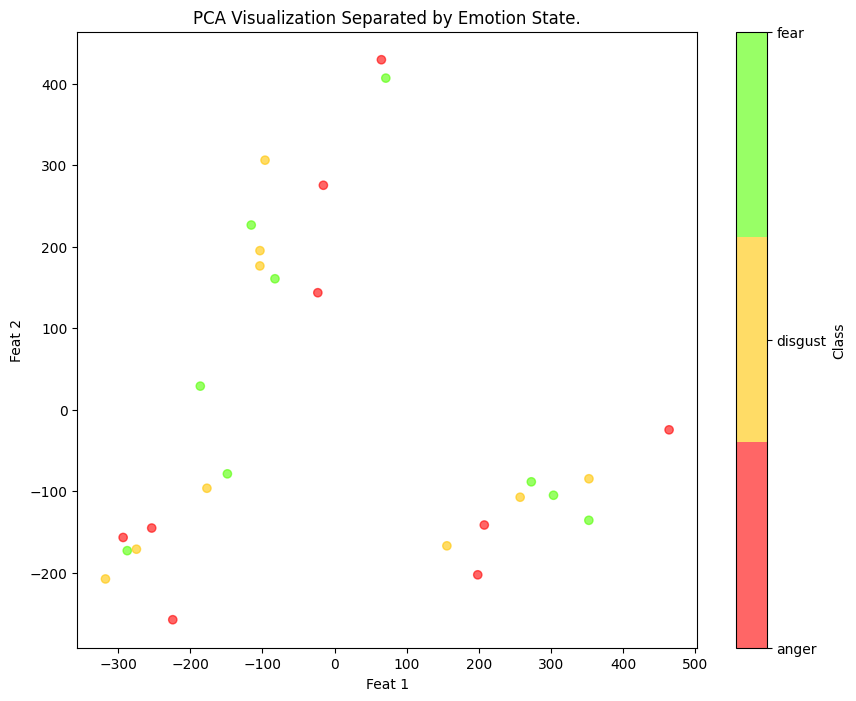

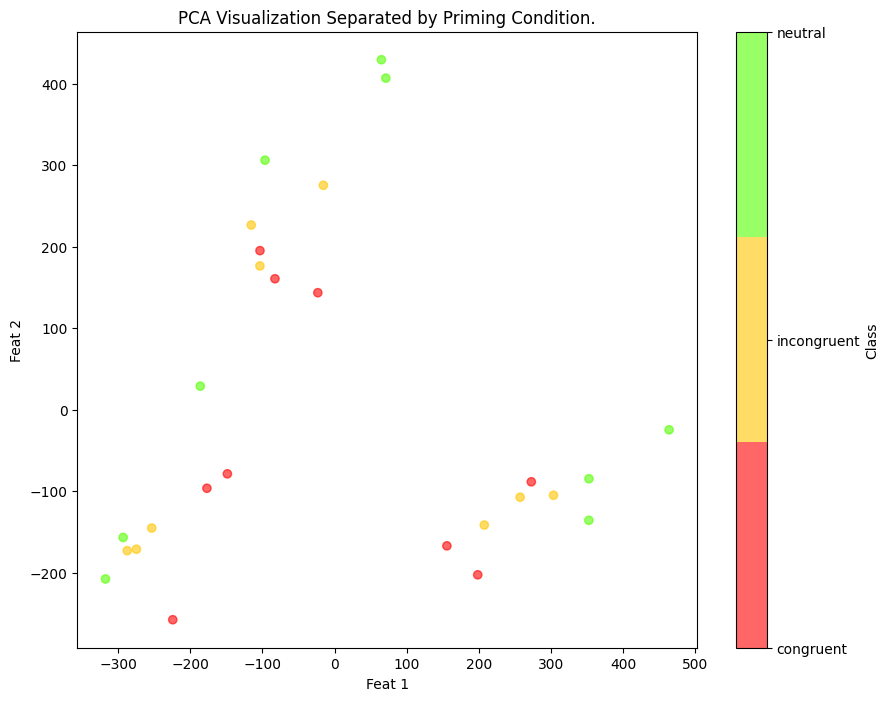

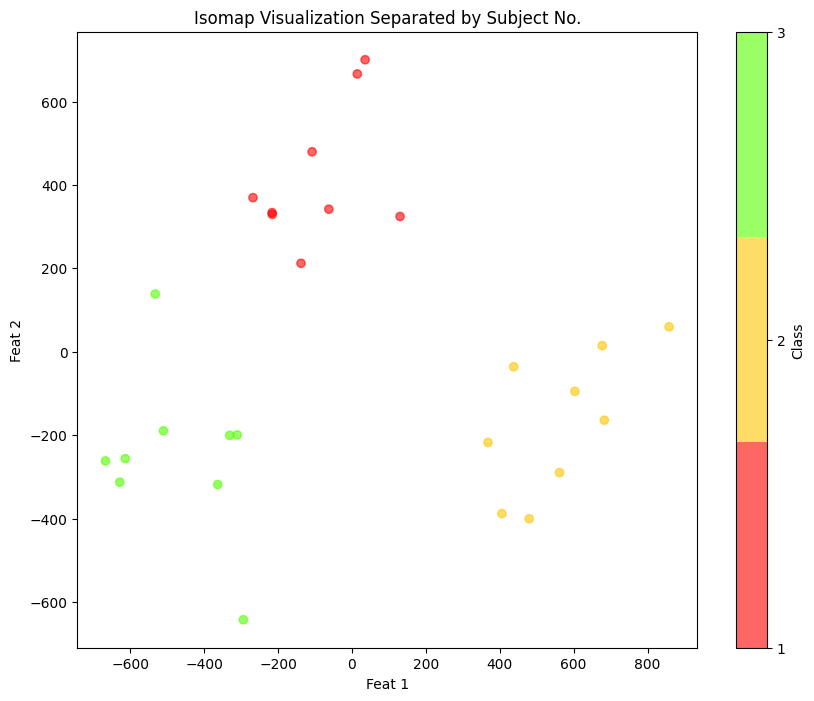

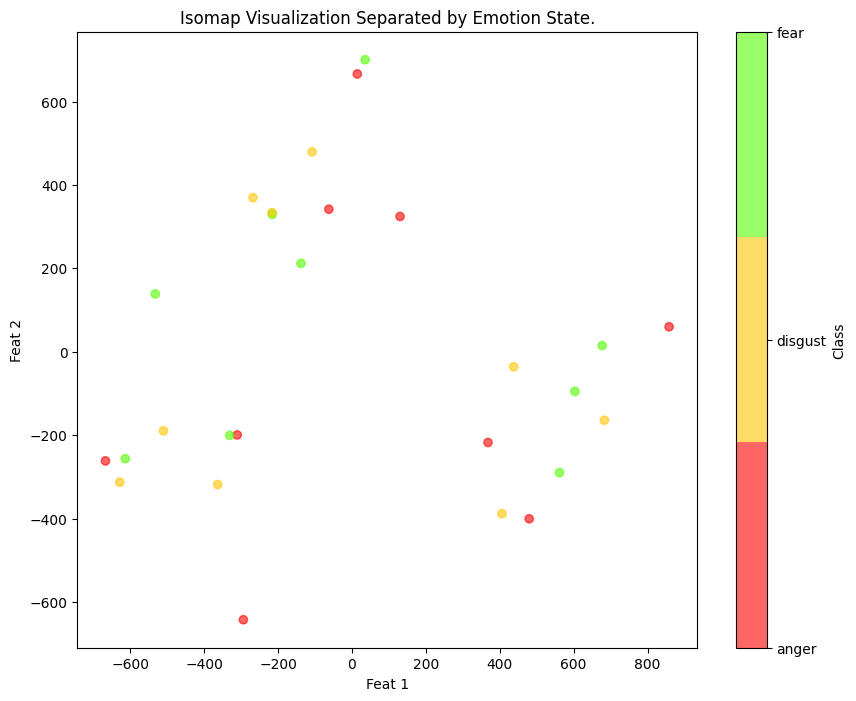

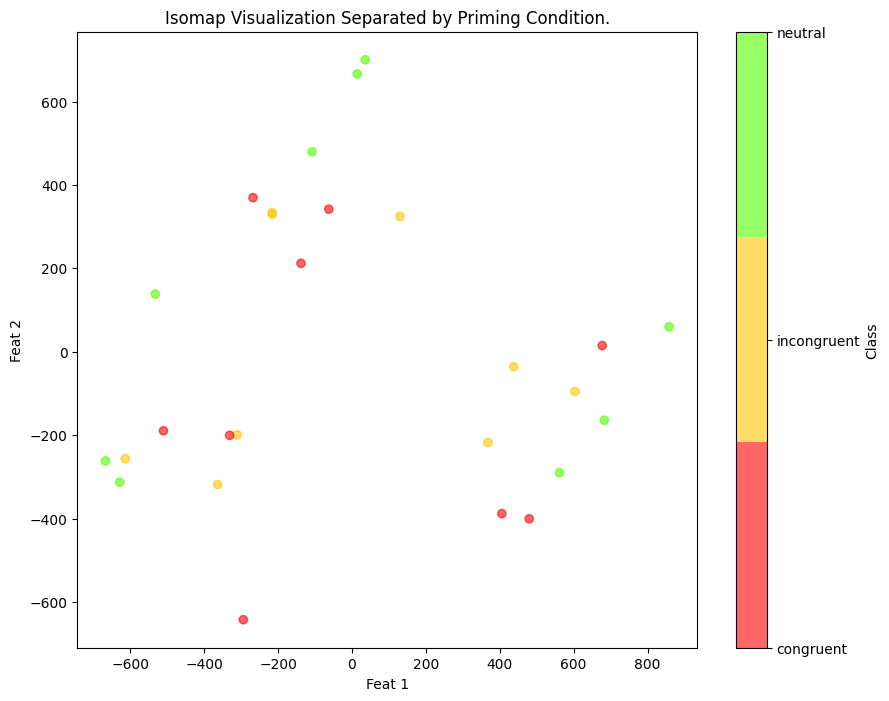

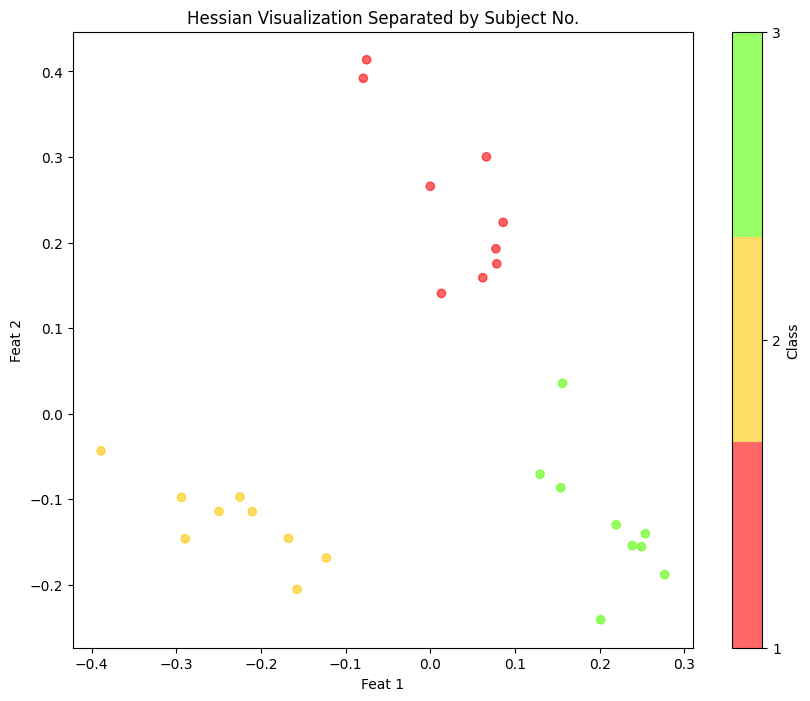

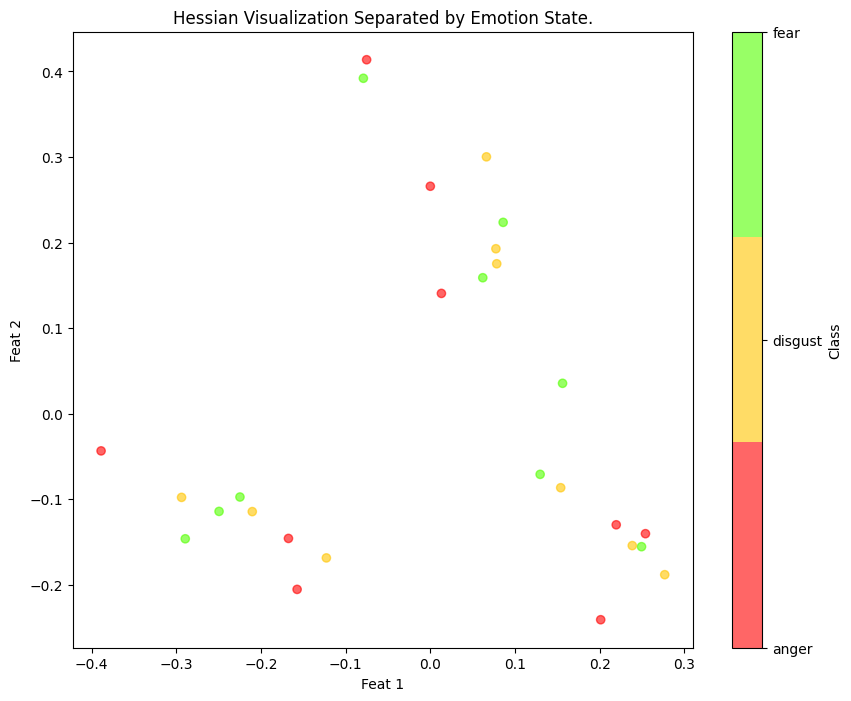

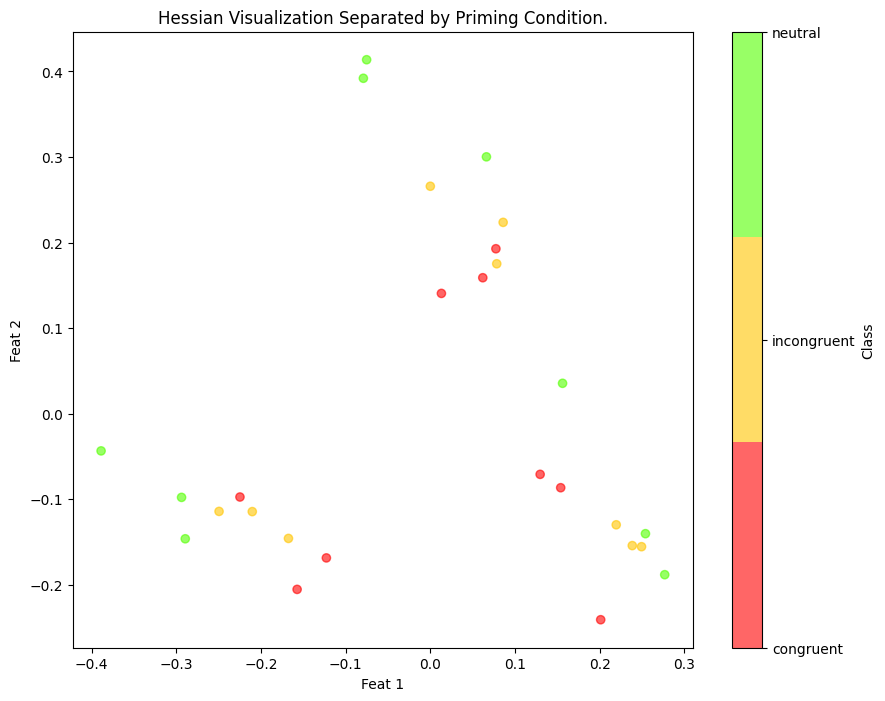

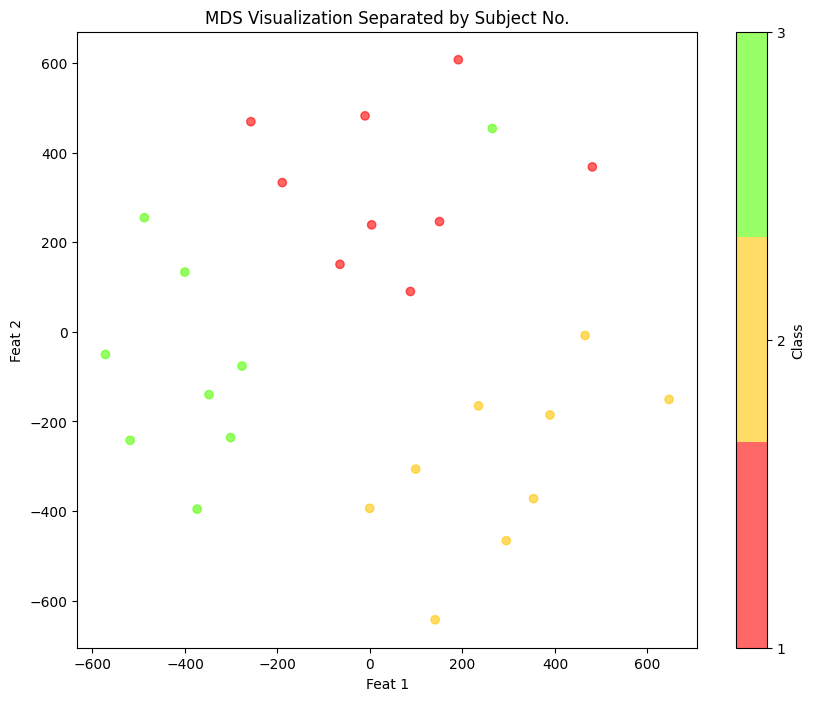

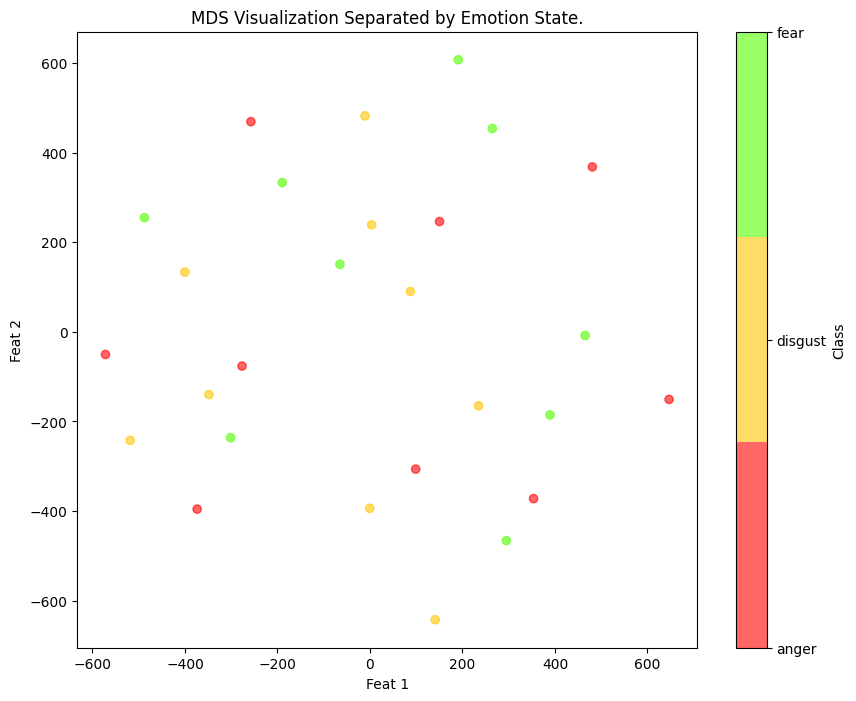

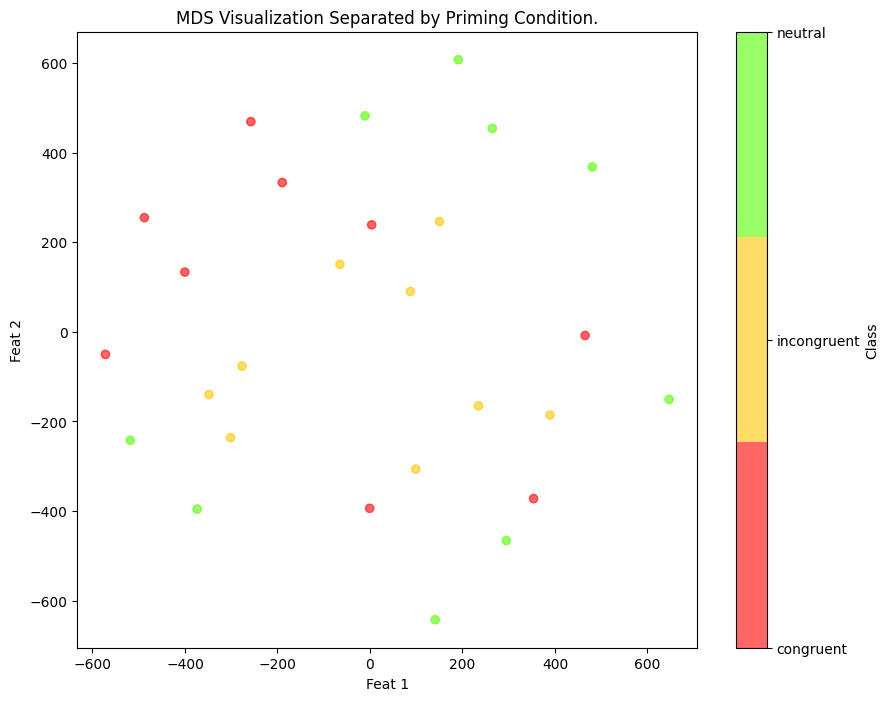

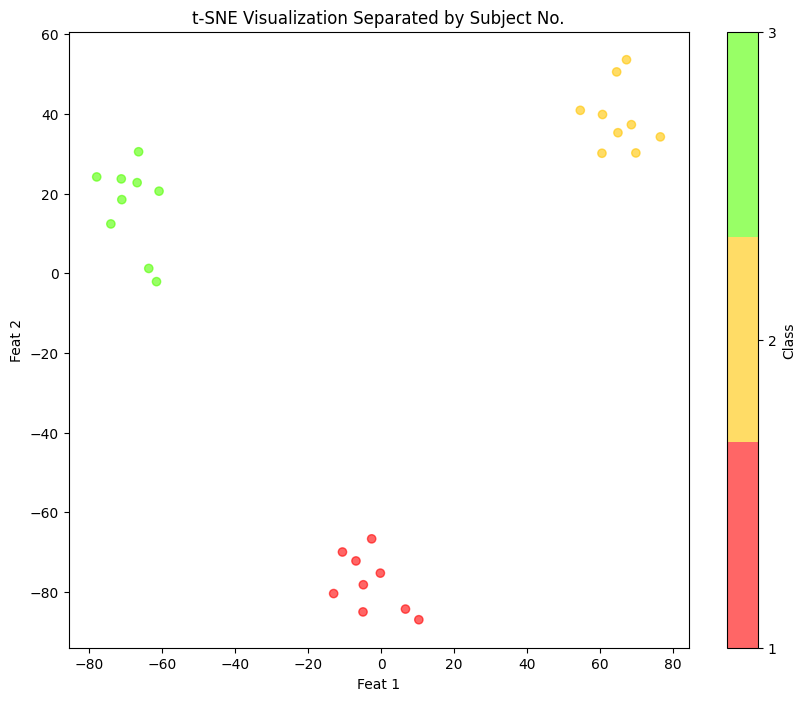

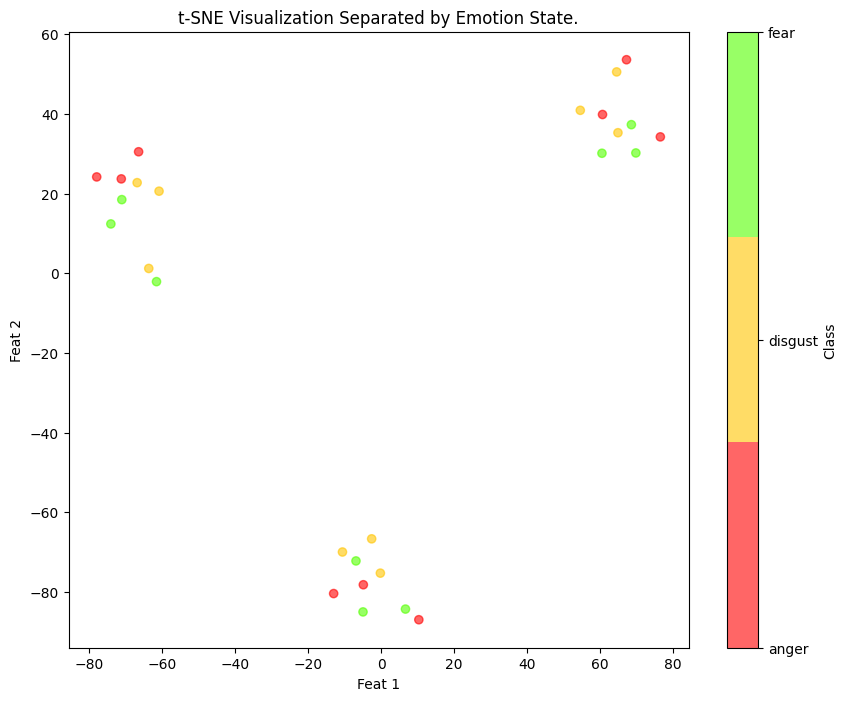

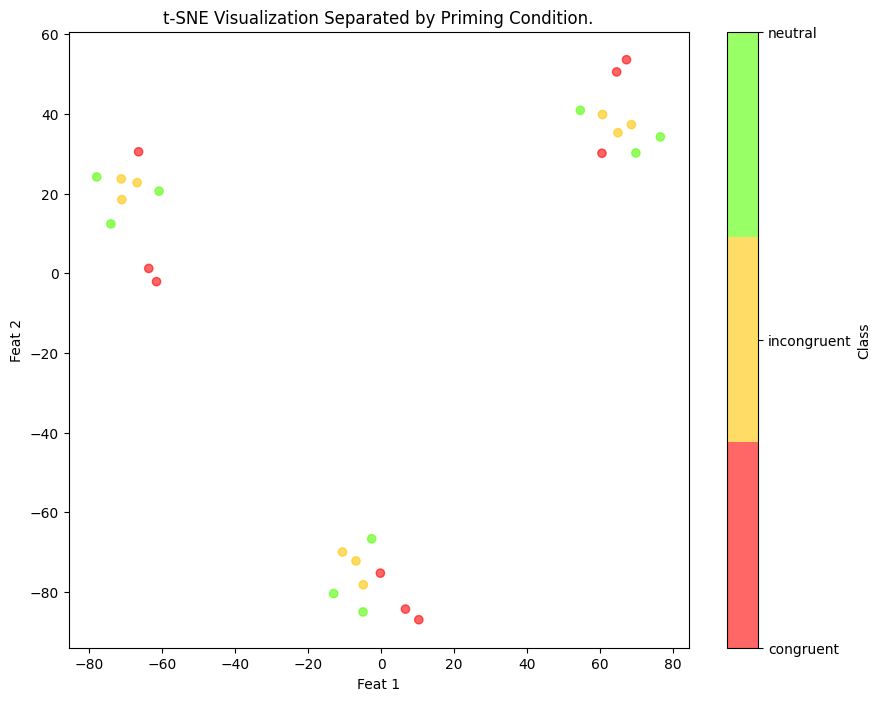

In [46]:
# plot results
for key in projection_2D.keys():
    
    plot_embeddings(projection_2D[key], subject_encoded, f"{key} Visualization Separated by Subject No.",
                    'subject', f"{key}_subject.png", label_encoder=le_subject)

    plot_embeddings(projection_2D[key], emotion_encoded, f"{key} Visualization Separated by Emotion State.",
                    'emotion', f"{key}_emotion.png", label_encoder=le_emotion)

    plot_embeddings(projection_2D[key], priming_encoded, f"{key} Visualization Separated by Priming Condition.",
                    'priming', f"{key}_priming.png", label_encoder=le_priming)

## **Check for Multicollinearity**

In [47]:
# correlation matrices
def corr_matrix(dataset, data_dict):

    # drop non-numeric or irrelevant columns
    columns_to_exclude = ['filename', 'emotion', 'priming']
    df = data_dict[dataset].drop(columns=columns_to_exclude, errors='ignore')
    
    # plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap for {dataset} Data")
    plt.tight_layout()
    plt.show()

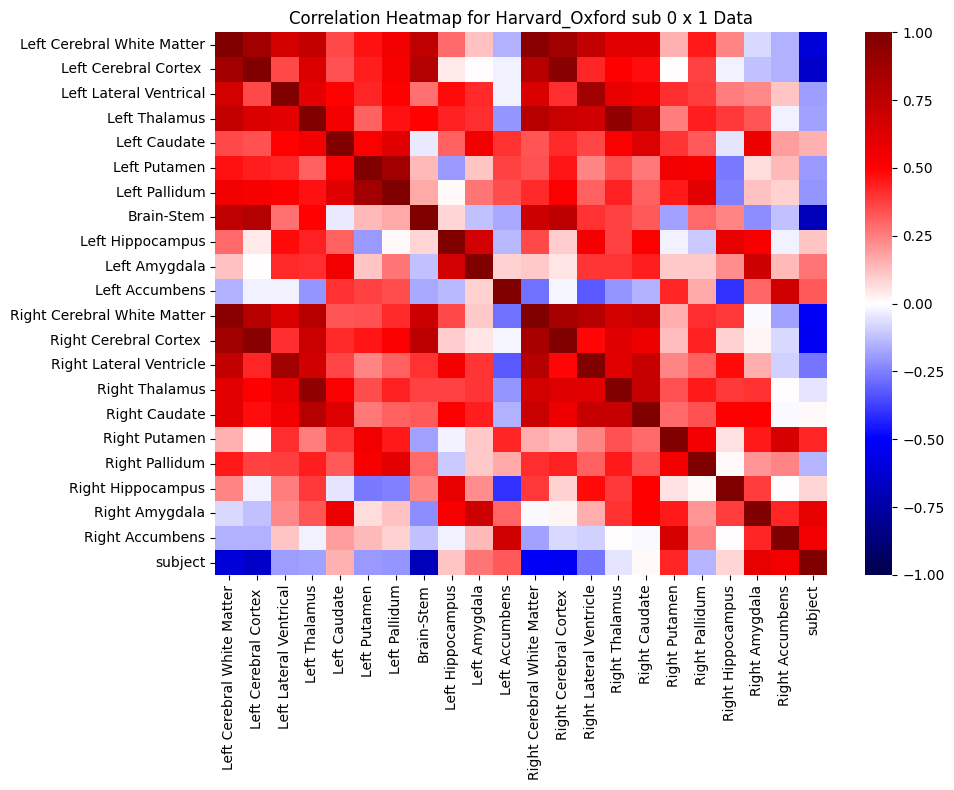

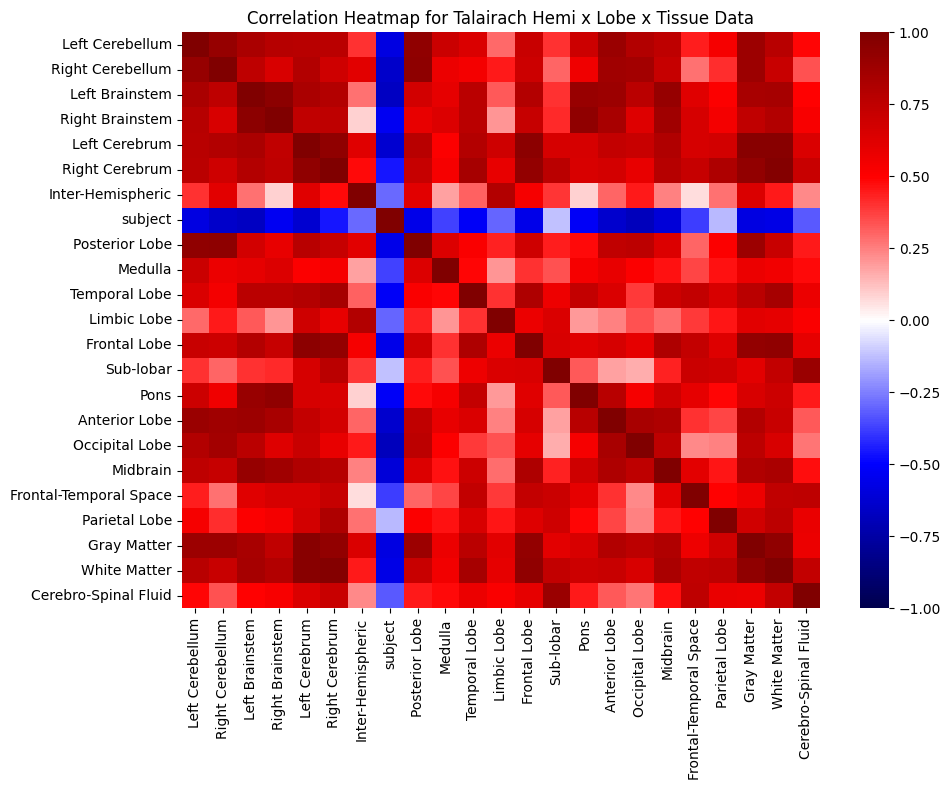

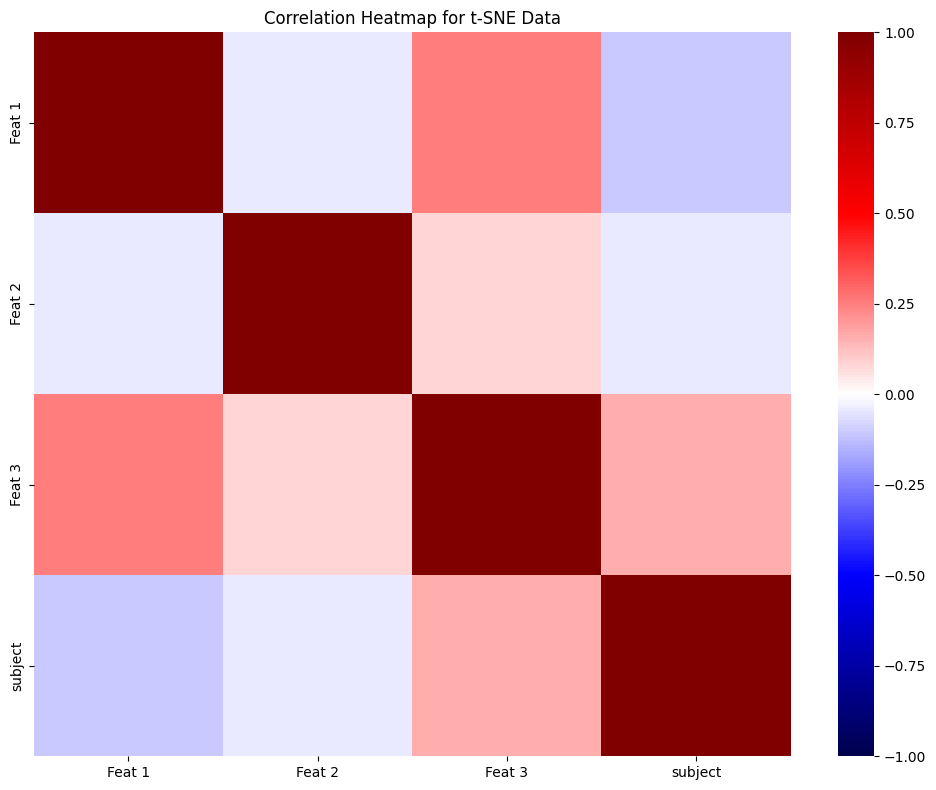

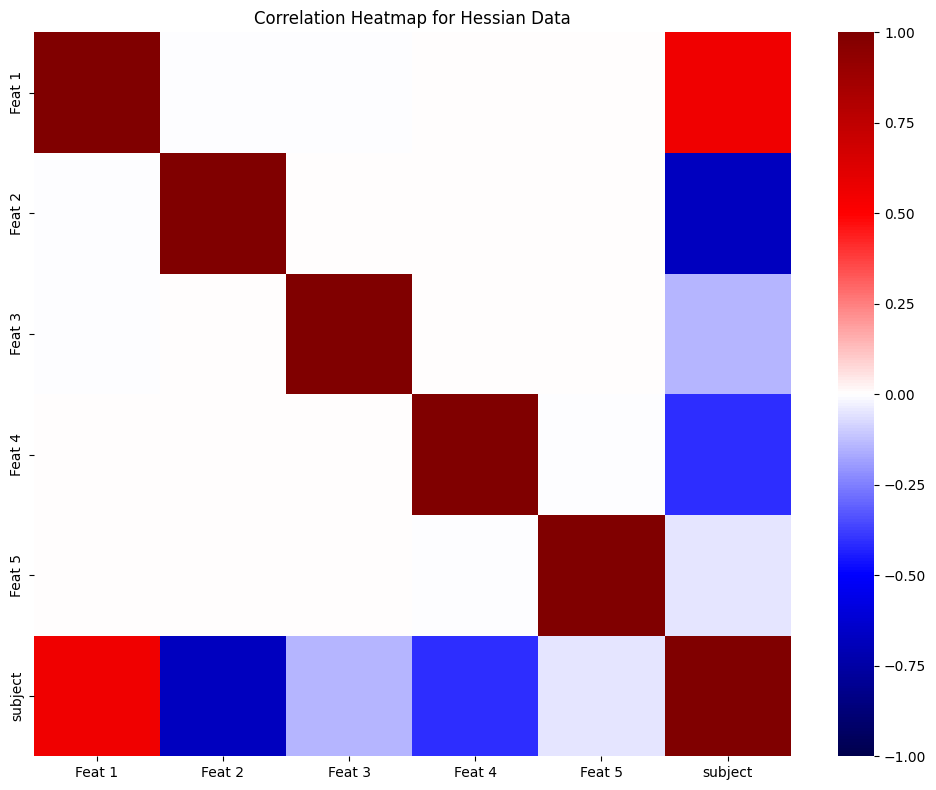

In [48]:
corr_matrix('Harvard_Oxford sub 0 x 1', parcellations)
corr_matrix('Talairach Hemi x Lobe x Tissue', parcellations)
corr_matrix('t-SNE', projections)
corr_matrix('Hessian', projections)

In [ ]:
def calc_vif(X):
    
    # create VIF dataframe for covariates
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [vif(X.values, i) for i in range(len(X.columns))]
    vif_data = vif_data.sort_values(by=['VIF'], ascending=False)
    
    return vif_data

In [ ]:
def del_multico(df, name, num):
    """
    purpose: removes multicollinear features from df based on VIF.

    params:
        df: pd.DataFrame: feature variables
        num: int : number of features to remove.

    output: percent: float: percentages of features that were removed for high VIF values
    """

    # select only float64 and int64 columns
    new_X = df.select_dtypes(include=['float64', 'int64']).copy()
    

    while True:

        # calculate VIF and check if below threshold
        vif_df = calc_vif(new_X)  
        if vif_df["VIF"].max() <= num:
            break 

        # find feature with the highest VIF and drop it
        feature_to_remove = vif_df.iloc[0]["feature"]
        new_X = new_X.drop(columns=[feature_to_remove])
        

    # calculate % of features remove for collinearity
    ratio = len(vif_df) / (len(df.columns) - 3)
    percent = 100 - (ratio * 100)

    # save vif dataframe
    vif_df.to_csv(f'./data/collinearity/{name}_vif.csv', index=False)
    
    return percent

In [ ]:
def plot_multicollinearity(data, name, num):
    '''
    purpose: visualize percentages of multicollineratiry in feature extraction methods
    params:
        data: dict: key, value pairs of dataset names and pd.DataFrames
        name: str: description of data subset
    output: none, plots and saves bar chart of % of multicollinearity based on VIF > 5
    '''

    # store values
    perc_multico = {}
    
    # for each dataset calculate % of the non-collinear features
    for key in data.keys():
        df = data[key]
        perc = del_multico(df, key, num)
        perc_multico[key] = perc

        # visualize percentages of multicollineratiry in brain parcellation features
        keys = list(perc_multico.keys())
        vals = list(perc_multico.values())
        
    plt.figure(figsize=(12, 6))
    plt.barh(keys, vals, color='#c80909')
    
    plt.title('Percentage of Features Dropped to Make All VIF Values < 5')
    plt.xlabel('Percent')
    plt.ylabel('Parcellations')
    
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'./visualizations/collinearity/{name}.png')
    plt.close()

In [ ]:
# identify which methods produce the most multicollinearity 
plot_multicollinearity(parcellations, 'Brain Parcellations', 5)
plot_multicollinearity(projections, 'Geometric Projections', 5)

## **Heterogeneity of Y Across X**

In [ ]:
def plot_heterogeneity_of_var(data, name):

    emo_p_values = {
        'feature': [],
        'p_value': [],
        'method': []
    }
    pri_p_values = {
        'feature': [],
        'p_value': [],
        'method': []
    }
    
    for method in data.keys():

        # select only on input column
        df = data[method]

        for input_col in df.columns:
            if (input_col == 'emotion') or (input_col == 'priming') or (input_col == 'subject') or (input_col == 'filename'):
                continue

            else:
                
                # get p values for each class comparison
                anger = df[df['emotion'] == 'anger'][input_col]
                disgust = df[df['emotion'] == 'disgust'][input_col]
                fear = df[df['emotion'] == 'fear'][input_col]
        
                con = df[df['priming'] == 'congruent'][input_col]
                incon = df[df['priming'] == 'incongruent'][input_col]
                neu = df[df['priming'] == 'neutral'][input_col]
        
                emo_stat, emo_p = stats.levene(anger, disgust, fear)
                pri_stat, pri_p = stats.levene(con, incon, neu)
        
                emo_p_values['p_value'].append(emo_p)
                emo_p_values['feature'].append(input_col)
                emo_p_values['method'].append(method)

                pri_p_values['p_value'].append(pri_p)
                pri_p_values['feature'].append(input_col)
                pri_p_values['method'].append(method)


                if emo_p <= 0.05:
                
                    # create a new figure and axes for each plot
                    plt.figure(figsize=(10, 6))
                    
                    # create the violin plot
                    sns.violinplot(data=df, x="emotion", y=input_col, hue="priming", fill=False, palette='prism')
                    
                    # add the title and labels
                    plt.title(f'Heterogeneity of Variance of {method} for {input_col} Over Emotion Classes')
                    plt.xlabel('Emotion Class')
                    plt.ylabel(f'{method} {input_col}')
                    plt.tight_layout()
                    
                    # save visual to directory
                    plt.savefig(f'./visualizations/heteroscedasticity/{method}_{input_col}_emo.png')
                    plt.close()

                if pri_p <= 0.05:
                
                    # create a new figure and axes for each plot
                    plt.figure(figsize=(10, 6))
                    
                    # create the violin plot
                    sns.violinplot(data=df, x="priming", y=input_col, hue="emotion", fill=False, palette='prism')
                    
                    # add the title and labels
                    plt.title(f'Heterogeneity of Variance of {method} for {input_col} Over Priming Classes')
                    plt.xlabel('Emotion Class')
                    plt.ylabel(f'{method} {input_col}')
                    plt.tight_layout()
                    
                    # save visual to directory
                    plt.savefig(f'./visualizations/heteroscedasticity/{method}_{input_col}_pri.png')
                    plt.close()


    
    # get p values for all methods
    emo_p_df = pd.DataFrame(emo_p_values)
    pri_p_df = pd.DataFrame(pri_p_values)

    emo_p_df.to_csv(f'./data/heteroscedasticity/{name}_feat_levene_emo.csv', index=False)
    pri_p_df.to_csv(f'./data/heteroscedasticity/{name}_feat_levene_pri.csv', index=False)

    
    

    # calculate percentage of p-values ≤ 0.05 for each method
    emo_sig_pct = emo_p_df.groupby('method').apply(lambda df: (df['p_value'] <= 0.05).mean() * 100)
    pri_sig_pct = pri_p_df.groupby('method').apply(lambda df: (df['p_value'] <= 0.05).mean() * 100)


    
    # plot % of significant p-values for emotion class
    plt.figure(figsize=(12, 6))
    plt.barh(emo_sig_pct.index, emo_sig_pct.values, color='#c80909')
    plt.title(f'Percent of Significant Levene Test P-values for Emotion Classes ({name})')
    plt.xlabel('% of p-values ≤ 0.05')
    plt.ylabel(f'{name} Methods')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'./visualizations/heteroscedasticity/{name}_emo_levene.png')
    plt.close()
    
    # plot % of significant p-values for priming class
    plt.figure(figsize=(12, 6))
    plt.barh(pri_sig_pct.index, pri_sig_pct.values, color='#c80909')
    plt.title(f'Percent of Significant Levene Test P-values for Priming Classes ({name})')
    plt.xlabel('% of p-values ≤ 0.05')
    plt.ylabel(f'{name} Methods')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'./visualizations/heteroscedasticity/{name}_pri_levene.png')
    plt.close()


In [ ]:
# identify which methods produce the most heteroscedasticity 
plot_heterogeneity_of_var(parcellations, 'Brain Parcellations')
plot_heterogeneity_of_var(projections, 'Geometric Projections')

## **Auto-Correlation Across Features**

In [ ]:
def measure_autocorrelation(method_dfs):

    # store correlations
    average_correlations = {}
    feature_correlations = {}
    
    for method, df in method_dfs.items():
        
        # ensure no modification of original data and only assess input features
        new_df = df.select_dtypes(include=['float64', 'int64']).copy()
    
        # correlate each feature with subject number
        feature_corrs = new_df.drop(columns='subject').corrwith(df['subject'])
        
        # Store detailed correlation DataFrame
        feature_correlations[method] = pd.DataFrame({
            'feature': feature_corrs.index,
            'corrcoef': feature_corrs.values
        })
    
        feature_correlations[method].to_csv(f'./data/autocorrelation/{method}.csv', index=False)
    
        # average absolute correlation
        average_correlations[method] = feature_correlations[method]['corrcoef'].abs().mean()
    
    # create DataFrame for plotting
    correlation_df = pd.DataFrame.from_dict(average_correlations, orient='index', columns=['Avg_Correlation'])
    correlation_df = correlation_df.sort_values('Avg_Correlation', ascending=False).reset_index()
    correlation_df.columns = ['Method', 'Avg_Correlation']
    
    # create and store visualization
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=correlation_df, x='Method', y='Avg_Correlation', palette='hsv')
    plt.title('Average Feature Autocorrelation with Subject Number by Method')
    plt.ylabel('Average Absolute Correlation')
    plt.xlabel('Feature Extraction Method')
    plt.xticks(rotation=85)
    plt.tight_layout()
    plt.savefig(f'./visualizations/autocorrelation/average_corrcoef_subject.png')
    plt.close()

In [ ]:
extracted_features = {**parcellations, **projections}
measure_autocorrelation(extracted_features)

# **Model Development**

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
        
    def logistic_regression(X, y, lr=0.5, epochs=100):
        
        # intialize 
        n_instances, m_feats = X.shape
        w = np.zeros(m_feats)
    
        for e in range(epochs): 
    
            # calculate logit of weighted sum
            y_pred = sigmoid(np.dot(X, w))
        
            # calculate errors (gradient)
            residuals = y_pred - y
        
            # update weights
            w -= (lr / n_instances) * np.dot(X.T, residuals)
    
        return w

In [ ]:
# remove redundancy
del extracted_features['Talairach Hemi']
del extracted_features['Talairach Tissue']
del extracted_features['Talairach Lobe']

feat_ex_methods = extracted_features.keys()

In [ ]:
class HierarchicalKFoldCV:

    def __init__(self, method, model, data_dict, hier_class, target_class, n_splits=5):
        self.data = data_dict[method]
        self.method = method
        self.hier_class = hier_class
        self.target_class = target_class
        self.n_splits = n_splits
        self.model_name = model

        if model == 'log_reg':
            self.model = LogisticRegression(penalty='l2', dual=False, multi_class='multinomial',
                                        warm_start=True, max_iter=5000)

        # For storing across folds
        self.all_coefs = []
        self.misclassified_records = []

        # intialize output directories
        base_path = f"./data/{model}_results"
        self.output_paths = {
            'confusions': f"{base_path}/confusion_matrices",
            'coefficients': f"{base_path}/coefficients",
            'classification_reports': f"{base_path}/classification_reports",
            'errors': f"{base_path}/errors",
            'metrics': f"{base_path}/metrics",
        }

    def _separate_input_target(self):
        X = self.data.select_dtypes(include=['float64', 'int64']).drop(columns=[self.target_class], errors='ignore')
        y = self.data[self.target_class]
        groups = self.data[self.hier_class]
        
        return X, y, groups

    def _save_model_weights(self, feature_names):
        avg_coef = np.mean(self.all_coefs, axis=0)
        classes = self.model.classes_

        if avg_coef.ndim == 1:
            avg_coef = avg_coef.reshape(1, -1)

        weights_df = pd.DataFrame(avg_coef, columns=feature_names)
        weights_df['class'] = classes
        weights_df = weights_df.set_index('class').transpose()
        weights_df.to_csv(f"{self.output_paths['coefficients']}/{self.method}_{self.target_class}.csv")

    def _compute_and_save_metrics(self, y_true, y_pred, dataset_type):

        try:
            proba = self.model.predict_proba(self.X_test if dataset_type == 'test' else self.X_train)
            roc_auc = roc_auc_score(y_true, proba, average='micro', multi_class='ovr')
        except:
            roc_auc = 0

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=np.nan)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(f"{self.output_paths['classification_reports']}/{self.method}_{self.target_class}_{dataset_type}.csv")

        return roc_auc

    def _save_confusion_matrix(self, y_true, y_pred, dataset_type):

        plt.figure(figsize=(8, 6))
        
        labels = unique_labels(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
       
        plt.title(f"{dataset_type.capitalize()} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig(f"{self.output_paths['confusions']}/{self.method}_{self.target_class}_{dataset_type}.png")
        plt.close()

    def _accumulate_misclassifications(self, X, y_true, y_pred):
        misclassified_mask = y_true != y_pred
        misclassified_indices = X.index[misclassified_mask]
    
        # full original rows
        misclassified = self.data.loc[misclassified_indices]
    
        # ensure Series alignment
        true_labels = y_true.loc[misclassified_indices].reset_index(drop=True)
        pred_labels = pd.Series(y_pred).iloc[misclassified_mask.values].reset_index(drop=True)
    
        misclassified_df = pd.concat([
            misclassified.reset_index(drop=True),
            true_labels.rename("true_label"),
            pred_labels.rename("predicted_label")
        ], axis=1)
    
        self.misclassified_records.append(misclassified_df)



    def _save_aggregated_misclassifications(self):
        if not self.misclassified_records:
            return
        all_misclassified = pd.concat(self.misclassified_records, ignore_index=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=PerformanceWarning)
            deduped = all_misclassified.groupby(all_misclassified.columns.tolist()).size().reset_index(name='error_count')
        deduped.to_csv(f"{self.output_paths['errors']}/{self.method}_{self.target_class}.csv", index=False)

    
    def evaluate(self):
        X, y, groups = self._separate_input_target()
        gkf = GroupKFold(n_splits=self.n_splits)

        train_roc_auc = 0
        test_roc_auc = 0

        for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
            self.X_train, self.X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # save most recent model configuration
            self.model.fit(self.X_train, y_train)
            joblib.dump(self.model, f'./data/models/{self.model_name}_fold_{fold}_target_class.pkl')
            self.all_coefs.append(self.model.coef_)

            y_pred_train = self.model.predict(self.X_train)
            y_pred_test = self.model.predict(self.X_test)

            train_roc_auc += self._compute_and_save_metrics(y_train, y_pred_train, "train")
            test_roc_auc += self._compute_and_save_metrics(y_test, y_pred_test, "test")


            self._save_confusion_matrix(y_train, y_pred_train, "train")
            self._save_confusion_matrix(y_test, y_pred_test, "test")

            self._accumulate_misclassifications(self.X_test.copy(), y_test, y_pred_test)

        # save averaged results
        self._save_model_weights(feature_names=self.X_train.columns)
        self._save_aggregated_misclassifications()

        

        return train_roc_auc/self.n_splits , test_roc_auc/self.n_splits , self.method, self.target_class, self.X_train.shape[1]

In [ ]:
roc_auc_dict = {'roc_train_emo': [], 'roc_test_emo': [], 'method': [], 
                'roc_train_pri': [], 'roc_test_pri': [], 'feature_count' : []}

for app in feat_ex_methods:
    
    # run model on all extracted feature methods
    tr_e, te_e, me_e, ta_e, fe_e = HierarchicalKFoldCV(method=app, data_dict=extracted_features, hier_class='subject', 
                                         target_class='emotion', n_splits=2, model='log_reg').evaluate()
    tr_p, te_p, me_p, ta_p, fe_p = HierarchicalKFoldCV(method=app, data_dict=extracted_features, hier_class='subject', 
                                         target_class='priming', n_splits=2, model='log_reg').evaluate()

    # store metric values for all extracted feature methods
    roc_auc_dict['roc_train_emo'].append(tr_e)
    roc_auc_dict['roc_test_emo'].append(te_e)
    roc_auc_dict['method'].append(app)
    roc_auc_dict['feature_count'].append(fe_e)
    roc_auc_dict['roc_train_pri'].append(tr_p)
    roc_auc_dict['roc_test_pri'].append(te_p)

pd.DataFrame(roc_auc_dict).to_csv('./data/log_reg_results/metrics/roc_auc.csv', index=False)

# **Interpretation & Analysis**

## **Multicollinearity Results**

<div style="text-align: center">
    <img src="./visualizations/collinearity/Brain Parcellations.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/collinearity/Geometric Projections.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/collinearity/Harvard_Oxford sub 0 x 1.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/collinearity/Talairach Hemi x Lobe x Tissue.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/collinearity/Hessian.png" alt="image" width="500" />
</div>

<div style="text-align: center">
    <img src="./visualizations/collinearity/t-SNE.png" alt="image" width="500" />
</div>


In [ ]:
# store complete VIF dataframes

# aggregate them all to one dataframe

# sort values and save csv

## **Homogeneity of Variance Results**

<div style="text-align: center">
    <img src="./visualizations/heteroscedasticity/Brain Parcellations_emo_levene.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/heteroscedasticity/Brain Parcellations_pri_levene.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/heteroscedasticity/Geometric Projections_emo_levene.png" alt="image" width="800" />
</div>

<div style="text-align: center">
    <img src="./visualizations/heteroscedasticity/Geometric Projections_pri_levene.png" alt="image" width="800" />
</div>

In [ ]:
# aggregate the levene p values to one dataframe

# sort values and save csv

## **Auto-correlation Results**

<div style="text-align: center">
    <img src="./visualizations/autocorrelation/average_corrcoef_subject.png" alt="image" width="1000" />
</div>



In [ ]:
# aggregate the correlation coefficients of input features to subject number to one dataframe

# sort values and save csv

## **Logistic Regression Results**

### 

**<h2 style="text-align: center;">TOP 5 EMOTION COEFFICIENTS BY FEATURE</h2>**

| feature                                   | method                         | label         |      coef |
|:------------------------------------------|:-------------------------------|:--------------|----------:|
| Parietal Lobe                             | Talairach Hemi x Lobe x Tissue | anger_coefs   | -0.486486 |
| Anterior Lobe                             | Talairach Hemi x Lobe x Tissue | anger_coefs   |  0.461686 |
| Left Amygdala                             | Harvard_Oxford sub 0 x 1       | anger_coefs   |  0.433992 |
| Frontal-Temporal Space                    | Talairach Hemi x Lobe x Tissue | anger_coefs   |  0.403429 |
| Right Amygdala                            | Harvard_Oxford sub 0 x 1       | anger_coefs   |  0.356208 |
| Parietal Lobe                             | Talairach Hemi x Lobe x Tissue | fear_coefs    |  0.624578 |
| Frontal-Temporal Space                    | Talairach Hemi x Lobe x Tissue | fear_coefs    | -0.474322 |
| Pons                                      | Talairach Hemi x Lobe x Tissue | fear_coefs    |  0.362779 |
| Supramarginal Gyrus, anterior division    | Harvard_Oxford cort 0 x 1      | fear_coefs    |  0.352647 |
| Feat 3                                    | Hessian                        | fear_coefs    | -0.336553 |
| Pons                                      | Talairach Hemi x Lobe x Tissue | disgust_coefs | -0.397541 |
| Parahippocampal Gyrus, posterior division | Harvard_Oxford cort 0 x 1      | disgust_coefs | -0.389372 |
| Supramarginal Gyrus, anterior division    | Harvard_Oxford cort 0 x 1      | disgust_coefs | -0.36195  |
| Anterior Commissure                       | Talairach Ba                   | disgust_coefs |  0.360123 |
| Superior Occipital Gyrus                  | Talairach Gyrus                | disgust_coefs | -0.344642 |

<br/>

**<h2 style="text-align: center;">TOP 5 PRIMING COEFFICIENTS BY FEATURE</h2>**

| feature                | method                         | label             |      coef |
|:-----------------------|:-------------------------------|:------------------|----------:|
| Feat 4                 | Hessian                        | neutral_coefs     | -0.57373  |
| Left Lateral Ventrical | Harvard_Oxford sub 0 x 1       | neutral_coefs     | -0.488483 |
| Cerebro-Spinal Fluid   | Talairach Hemi x Lobe x Tissue | neutral_coefs     | -0.466098 |
| Temporal Lobe          | Talairach Hemi x Lobe x Tissue | neutral_coefs     |  0.414796 |
| Feat 1                 | MDS                            | neutral_coefs     |  0.40016  |
| Feat 3                 | Hessian                        | congruent_coefs   | -0.593475 |
| Cerebro-Spinal Fluid   | Talairach Hemi x Lobe x Tissue | congruent_coefs   |  0.528018 |
| Occipital Lobe         | Talairach Hemi x Lobe x Tissue | congruent_coefs   | -0.521941 |
| Left Lateral Ventrical | Harvard_Oxford sub 0 x 1       | congruent_coefs   |  0.520988 |
| Medulla                | Talairach Hemi x Lobe x Tissue | congruent_coefs   |  0.449377 |
| Occipital Lobe         | Talairach Hemi x Lobe x Tissue | incongruent_coefs |  0.842868 |
| Temporal Lobe          | Talairach Hemi x Lobe x Tissue | incongruent_coefs | -0.466435 |
| Brodmann area 17       | Talairach Ba                   | incongruent_coefs |  0.461788 |
| Right Caudate          | Harvard_Oxford sub 0 x 1       | incongruent_coefs | -0.425085 |
| Lingual Gyrus          | Talairach Gyrus                | incongruent_coefs |  0.389885 |


<br/>

**<h2 style="text-align: center;">ROC AUC SCORES BY METHOD</h2>**

|    |   roc_train_emo |   roc_test_emo | method                         |   roc_train_pri |   roc_test_pri |   feature_count |   emo_overfit |   pri_overfit |
|---:|----------------:|---------------:|:-------------------------------|----------------:|---------------:|----------------:|--------------:|--------------:|
|  0 |        1        |       0.527778 | Harvard_Oxford cort 0 x 1      |        1        |       0.885802 |              49 |      0.527778 |      0.885802 |
|  1 |        1        |       0.510031 | Harvard_Oxford cortl 0 x 1     |        1        |       0.868827 |              97 |      0.510031 |      0.868827 |
|  2 |        0.999228 |       0.506944 | Harvard_Oxford sub 0 x 1       |        1        |       0.553241 |              22 |      0.507336 |      0.553241 |
|  3 |        1        |       0.45679  | Juelich 0 x 1                  |        1        |       0.821759 |              63 |      0.45679  |      0.821759 |
|  4 |        1        |       0.51929  | AAL SPM12                      |        1        |       0.793981 |             117 |      0.51929  |      0.793981 |
|  5 |        1        |       0.520062 | Talairach Gyrus                |        1        |       0.936728 |              56 |      0.520062 |      0.936728 |
|  6 |        1        |       0.518519 | Talairach Ba                   |        1        |       0.762346 |              72 |      0.518519 |      0.762346 |
|  7 |        1        |       0.487654 | Schaefer 100 x 7 x 1           |        1        |       0.895833 |             101 |      0.487654 |      0.895833 |
|  8 |        0.986883 |       0.557099 | Talairach Hemi x Lobe x Tissue |        0.996914 |       0.780864 |              23 |      0.564504 |      0.783282 |
|  9 |        1        |       0.529321 | PCA                            |        1        |       0.958333 |              26 |      0.529321 |      0.958333 |
| 10 |        0.899691 |       0.595679 | Isomap                         |        0.99537  |       0.539738 |               6 |      0.662093 |      0.542248 |
| 11 |        0.694444 |       0.63966  | Hessian                        |        0.909722 |       0.746914 |               6 |      0.921111 |      0.821035 |
| 12 |        0.908951 |       0.540895 | MDS                            |        1        |       0.625    |               6 |      0.595076 |      0.625    |
| 13 |        0.771605 |       0.486111 | t-SNE                          |        0.869599 |       0.528549 |               4 |      0.63     |      0.607808 |


<br />

**<h2 style="text-align: center;">F1 SCORES BY METHOD</h2>**

|    | method                         | label       |         f1 |
|---:|:-------------------------------|:------------|-----------:|
|  0 | Harvard_Oxford cortl 0 x 1     | congruent   |   0.857143 |
|  1 | Talairach Gyrus                | congruent   |   0.857143 |
|  2 | PCA                            | congruent   |   0.857143 |
|  3 | Schaefer 100 x 7 x 1           | congruent   |   0.8      |
|  4 | Harvard_Oxford cort 0 x 1      | congruent   |   0.75     |
|  5 | Schaefer 100 x 7 x 1           | incongruent |   0.857143 |
|  6 | AAL SPM12                      | incongruent |   0.8      |
|  7 | Talairach Gyrus                | incongruent |   0.8      |
|  8 | PCA                            | incongruent |   0.8      |
|  9 | Harvard_Oxford cort 0 x 1      | incongruent |   0.666667 |
| 10 | Juelich 0 x 1                  | neutral     |   1        |
| 11 | Talairach Gyrus                | neutral     |   1        |
| 12 | Schaefer 100 x 7 x 1           | neutral     |   1        |
| 13 | PCA                            | neutral     |   1        |
| 14 | Hessian                        | neutral     |   1        |
| 15 | Talairach Hemi x Lobe x Tissue | anger       |   0.571429 |
| 16 | Juelich 0 x 1                  | anger       |   0.5      |
| 17 | Talairach Gyrus                | anger       |   0.5      |
| 18 | Talairach Ba                   | anger       |   0.5      |
| 19 | Schaefer 100 x 7 x 1           | anger       |   0.5      |
| 20 | Harvard_Oxford sub 0 x 1       | disgust     |   0.666667 |
| 21 | Hessian                        | disgust     |   0.666667 |
| 22 | Talairach Hemi x Lobe x Tissue | disgust     |   0.5      |
| 23 | PCA                            | disgust     |   0.5      |
| 24 | AAL SPM12                      | disgust     |   0.333333 |
| 25 | Talairach Hemi x Lobe x Tissue | fear        |   0.571429 |
| 26 | Hessian                        | fear        |   0.571429 |
| 27 | Harvard_Oxford cort 0 x 1      | fear        |   0.5      |
| 28 | t-SNE                          | fear        |   0.4      |
| 29 | Harvard_Oxford cortl 0 x 1     | fear        | nan        |

<br />

**<h2 style="text-align: center;">CHI-SQUARE ASSOCIATION FOR RESIDUALS</h2>**

|     | method                         | target   | feat_1          | feat_2          |     p_value |
|----:|:-------------------------------|:---------|:----------------|:----------------|------------:|
|   2 | Harvard_Oxford cort 0 x 1      | emotion  | subject         | predicted_label | 0.00248955  |
|   5 | Harvard_Oxford cort 0 x 1      | emotion  | emotion         | predicted_label | 0.0409828   |
|   9 | Harvard_Oxford cort 0 x 1      | emotion  | predicted_label | subject         | 0.00248955  |
|  10 | Harvard_Oxford cort 0 x 1      | emotion  | predicted_label | emotion         | 0.0409828   |
|  26 | Harvard_Oxford cortl 0 x 1     | emotion  | subject         | predicted_label | 0.00327299  |
|  29 | Harvard_Oxford cortl 0 x 1     | emotion  | emotion         | predicted_label | 0.0474746   |
|  33 | Harvard_Oxford cortl 0 x 1     | emotion  | predicted_label | subject         | 0.00327299  |
|  34 | Harvard_Oxford cortl 0 x 1     | emotion  | predicted_label | emotion         | 0.0474746   |
|  50 | Harvard_Oxford sub 0 x 1       | emotion  | subject         | predicted_label | 0.0200692   |
|  53 | Harvard_Oxford sub 0 x 1       | emotion  | emotion         | predicted_label | 0.011109    |
|  57 | Harvard_Oxford sub 0 x 1       | emotion  | predicted_label | subject         | 0.0200692   |
|  58 | Harvard_Oxford sub 0 x 1       | emotion  | predicted_label | emotion         | 0.011109    |
|  62 | Harvard_Oxford sub 0 x 1       | priming  | subject         | predicted_label | 0.000426664 |
|  69 | Harvard_Oxford sub 0 x 1       | priming  | predicted_label | subject         | 0.000426664 |
|  74 | Juelich 0 x 1                  | emotion  | subject         | predicted_label | 0.00012341  |
|  77 | Juelich 0 x 1                  | emotion  | emotion         | predicted_label | 0.011109    |
|  81 | Juelich 0 x 1                  | emotion  | predicted_label | subject         | 0.00012341  |
|  82 | Juelich 0 x 1                  | emotion  | predicted_label | emotion         | 0.011109    |
|  85 | Juelich 0 x 1                  | priming  | subject         | priming         | 0.0236412   |
|  90 | Juelich 0 x 1                  | priming  | priming         | subject         | 0.0236412   |
|  98 | AAL SPM12                      | emotion  | subject         | predicted_label | 0.0173513   |
| 101 | AAL SPM12                      | emotion  | emotion         | predicted_label | 0.0367147   |
| 105 | AAL SPM12                      | emotion  | predicted_label | subject         | 0.0173513   |
| 106 | AAL SPM12                      | emotion  | predicted_label | emotion         | 0.0367147   |
| 116 | AAL SPM12                      | priming  | priming         | predicted_label | 0.0183156   |
| 119 | AAL SPM12                      | priming  | predicted_label | priming         | 0.0183156   |
| 122 | Talairach Gyrus                | emotion  | subject         | predicted_label | 0.00153966  |
| 125 | Talairach Gyrus                | emotion  | emotion         | predicted_label | 0.0306535   |
| 129 | Talairach Gyrus                | emotion  | predicted_label | subject         | 0.00153966  |
| 130 | Talairach Gyrus                | emotion  | predicted_label | emotion         | 0.0306535   |
| 146 | Talairach Ba                   | emotion  | subject         | predicted_label | 0.0246763   |
| 149 | Talairach Ba                   | emotion  | emotion         | predicted_label | 0.0197529   |
| 153 | Talairach Ba                   | emotion  | predicted_label | subject         | 0.0246763   |
| 154 | Talairach Ba                   | emotion  | predicted_label | emotion         | 0.0197529   |
| 170 | Schaefer 100 x 7 x 1           | emotion  | subject         | predicted_label | 0.000240714 |
| 173 | Schaefer 100 x 7 x 1           | emotion  | emotion         | predicted_label | 0.0173513   |
| 177 | Schaefer 100 x 7 x 1           | emotion  | predicted_label | subject         | 0.000240714 |
| 178 | Schaefer 100 x 7 x 1           | emotion  | predicted_label | emotion         | 0.0173513   |
| 182 | Schaefer 100 x 7 x 1           | priming  | subject         | predicted_label | 0.011109    |
| 189 | Schaefer 100 x 7 x 1           | priming  | predicted_label | subject         | 0.011109    |
| 194 | Talairach Hemi x Lobe x Tissue | emotion  | subject         | predicted_label | 0.036566    |
| 201 | Talairach Hemi x Lobe x Tissue | emotion  | predicted_label | subject         | 0.036566    |
| 206 | Talairach Hemi x Lobe x Tissue | priming  | subject         | predicted_label | 0.011202    |
| 213 | Talairach Hemi x Lobe x Tissue | priming  | predicted_label | subject         | 0.011202    |
| 221 | PCA                            | emotion  | emotion         | predicted_label | 0.0296905   |
| 226 | PCA                            | emotion  | predicted_label | emotion         | 0.0296905   |
| 242 | Isomap                         | emotion  | subject         | predicted_label | 5.91545e-05 |
| 249 | Isomap                         | emotion  | predicted_label | subject         | 5.91545e-05 |
| 260 | Isomap                         | priming  | priming         | predicted_label | 0.00413243  |
| 263 | Isomap                         | priming  | predicted_label | priming         | 0.00413243  |
| 284 | Hessian                        | priming  | priming         | predicted_label | 0.0376369   |
| 287 | Hessian                        | priming  | predicted_label | priming         | 0.0376369   |
| 288 | MDS                            | emotion  | subject         | emotion         | 0.0443932   |
| 290 | MDS                            | emotion  | subject         | predicted_label | 0.000203468 |
| 291 | MDS                            | emotion  | emotion         | subject         | 0.0443932   |
| 293 | MDS                            | emotion  | emotion         | predicted_label | 0.00754025  |
| 297 | MDS                            | emotion  | predicted_label | subject         | 0.000203468 |
| 298 | MDS                            | emotion  | predicted_label | emotion         | 0.00754025  |
| 308 | MDS                            | priming  | priming         | predicted_label | 0.0352442   |
| 311 | MDS                            | priming  | predicted_label | priming         | 0.0352442   |
| 317 | t-SNE                          | emotion  | emotion         | predicted_label | 0.00537281  |
| 322 | t-SNE                          | emotion  | predicted_label | emotion         | 0.00537281  |

In [ ]:
# get directories to find and store data
input_dir = "./data/log_reg_results/coefficients"
output_dir = "./data/interpretation"

def merge_all_coefs(label, col_names):
    dfs = []

    for method in feat_ex_methods:
        filename = f"{method}_{label}.csv"
        file_path = os.path.join(input_dir, filename)

        df = pd.read_csv(file_path)
        df = df.rename(columns={"Unnamed: 0": "feature"})
        df['method'] = [method] * len(df)
        dfs.append(df)

    # Vertical concat
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    merged_df = merged_df.rename(columns=col_names)
    merged_df.to_csv(os.path.join(output_dir, f"coef_{label}.csv"), index=False)

    

# run for both labels
merge_all_coefs("emotion", {'anger': 'anger_coefs', 'fear': 'fear_coefs', 'disgust': 'disgust_coefs'})
merge_all_coefs("priming", {'incongruent': 'incongruent_coefs', 'congruent': 'congruent_coefs', 'neutral': 'neutral_coefs'})

In [ ]:
def save_top_coef_features(df, coef_columns, output_filename, top_n=5):
    
    top_features = []

    for col in coef_columns:
        
        df_sorted = df[['feature', 'method', col]].copy()
        df_sorted['abs_val'] = df_sorted[col].abs()
        df_sorted = df_sorted.sort_values(by='abs_val', ascending=False).head(top_n)

       
        df_sorted['label'] = col
        df_sorted = df_sorted[['feature', 'method', 'label', col]]
        df_sorted = df_sorted.rename(columns={col: 'coef'})

        top_features.append(df_sorted)


    top_df = pd.concat(top_features, ignore_index=True)
    top_df.to_csv(output_filename, index=False)



In [ ]:
coef_emotion = pd.read_csv('./data/interpretation/coef_emotion.csv')
coef_priming = pd.read_csv('./data/interpretation/coef_priming.csv')

save_top_coef_features(coef_emotion, ['anger_coefs', 'fear_coefs', 'disgust_coefs'], './data/interpretation/top_coef_emotion.csv')
save_top_coef_features(coef_priming, ['neutral_coefs', 'congruent_coefs', 'incongruent_coefs'], './data/interpretation/top_coef_priming.csv')

In [ ]:
roc_auc_scores = pd.read_csv('./data/log_reg_results/metrics/roc_auc.csv')
roc_auc_scores['emo_overfit'] = roc_auc_scores['roc_test_emo'] / roc_auc_scores['roc_train_emo']
roc_auc_scores['pri_overfit'] = roc_auc_scores['roc_test_pri'] / roc_auc_scores['roc_train_pri']
print(roc_auc_scores.to_markdown())

In [ ]:
# directories
input_dir = "./data/log_reg_results/classification_reports"
output_file = "./data/interpretation/f1_scores.csv"

def merge_f1_scores(feat_ex_methods):
    rows = []

    for method in feat_ex_methods:
        row = {
            "method": method,
            "congruent": None,
            "incongruent": None,
            "neutral": None,
            "anger": None,
            "disgust": None,
            "fear": None
        }

        for label in ["priming", "emotion"]:
            filename = f"{method}_{label}_test.csv"
            file_path = os.path.join(input_dir, filename)

            if not os.path.exists(file_path):
                continue

            df = pd.read_csv(file_path)
            df = df.rename(columns={"Unnamed: 0": "class"})
            df = df.set_index("class")

            for target_class in row.keys():
                if target_class in df.index:
                    row[target_class] = df.loc[target_class, "f1-score"]

        rows.append(row)

    final_df = pd.DataFrame(rows)
    final_df.to_csv(output_file, index=False)


merge_f1_scores(feat_ex_methods)
f1_scores = pd.read_csv(output_file)

In [ ]:
def save_top_f1_methods(df, cols, output_filename, top_n=5):
    
    top_features = []

    for col in cols:
        
        # Sort by absolute value of coefficient, descending
        df_sorted = df[['method', col]].copy()
        df_sorted = df_sorted.sort_values(by=col, ascending=False).head(top_n)

        # Add label info
        df_sorted['label'] = col
        df_sorted = df_sorted[['method', 'label', col]]
        df_sorted = df_sorted.rename(columns={col: 'f1'})

        top_features.append(df_sorted)

    # Combine and save
    top_df = pd.concat(top_features, ignore_index=True)
    top_df.to_csv(output_filename, index=False)

In [ ]:
f1_file = './data/interpretation/top_f1.csv'
save_top_f1_methods(f1_scores, ['congruent', 'incongruent', 'neutral', 'anger', 'disgust', 'fear'], 
                       f1_file, top_n=5)
#print(pd.read_csv(f1_file).to_markdown())

In [ ]:
# chi square association for misclassified samples
cat_vars = ['subject', 'emotion', 'priming', 'predicted_label']
cat_var_pairs = [(a, b) for a, b in product(cat_vars, repeat=2) if a != b]

results = []

for method in feat_ex_methods:
    for target in ['emotion', 'priming']:
        # Load data
        df_path = f'./data/log_reg_results/errors/{method}_{target}.csv'
        df = pd.read_csv(df_path)

        for feat1, feat2 in cat_var_pairs:
            try:
                contingency_table = pd.crosstab(df[feat1], df[feat2])
                _, p_value, _, _ = stats.chi2_contingency(contingency_table)
                results.append({
                    'method': method,
                    'target': target,
                    'feat_1': feat1,
                    'feat_2': feat2,
                    'p_value': p_value
                })
            except Exception as e:
                print(f"Error in chi-squared test for {method} - {target} - {feat1} vs {feat2}: {e}")


results_df = pd.DataFrame(results)


output_path = './data/interpretation/chi_squared_cat_var_associations.csv'
results_df.to_csv(output_path, index=False)

In [ ]:
print(results_df[results_df['p_value'] <= .05].to_markdown())

## **Relationship Between Results**

Visualize pair plot for feature-based analysis: model coefficients, autocorrelation coefficients, vif
Visualize pair plot for method-based analysis: feature count, f1, roc_auc 

In [ ]:
# join all feature-focused dataframes on "feature" column

# join all method-focused dataframes on "method" column

# identify the relationship between methods collected at each stage of the investigation